# Working with Reve in Pixeltable

Pixeltable's Reve integration lets you call Reve's `create`, `edit`, and `remix` endpoints directly from tables so you can iterate on visuals without leaving your data workflows.

### Prerequisites
- A Reve account with an API key (<https://app.reve.com/> → Settings → API Keys)

### Important Notes
- Reve usage incurs costs according to your plan—keep an eye on credits.
- Images you send to Reve leave your environment; avoid uploading sensitive or private data.

First you'll install the required libraries and provide the `REVE_API_KEY`. Then we'll walk through each Reve endpoint—`create`, `edit`, and `remix`—one at a time using a single Pixeltable table so you can reuse the same assets across every step.


In [1]:
%pip install -qU pixeltable

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import getpass

if 'REVE_API_KEY' not in os.environ:
    os.environ['REVE_API_KEY'] = getpass.getpass('Reve API Key: ')

Now let's create a Pixeltable directory to keep the tables for this demo separate from anything else you're working on.

In [3]:
import pixeltable as pxt

In [4]:
pxt.create_dir('reve_demo', if_exists='replace_force')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata
Created directory 'reve_demo'.


## Generate new imagery with `reve.create`

Use `reve.create()` when you want Reve to synthesize an entirely new image from a prompt. Here we ask for a solarpunk oasis city.

First, we will create an empty single Pixeltable table to save the prompt in one column, and add the generated output from Reve to a separate column.

In [5]:
reve_t = pxt.create_table('reve_demo.assets', {'prompt': pxt.String})

Created table 'assets'.


In [6]:
reve_t

table 'reve_demo.assets'

 Column Name    Type Computed With
      prompt  String

Start by adding a single row that only contains a text prompt. We'll generate fresh imagery from this prompt before introducing any reference photos. Feel free to change the prompt—here we use your solarpunk skyline description.

In [7]:
prompt_text = 'A solarpunk metropolis in the desert with urban agriculture and an oasis theme.'
reve_t.insert(prompt=prompt_text)

Inserting rows into `assets`: 1 rows [00:00, 186.89 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 1 value computed.

We've still just added a single string as a text prompt.

In [8]:
reve_t.collect()

prompt
A solarpunk metropolis in the desert with urban agriculture and an oasis theme.


Next, we'll actually call the `reve.create()` function inside a computed column, giving it our prompt as input. 

In [9]:
from pixeltable.functions import reve

reve_t.add_computed_column(
    new_image=reve.create(
        reve_t.prompt
    )
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

prompt,new_image
A solarpunk metropolis in the desert with urban agriculture and an oasis theme.,

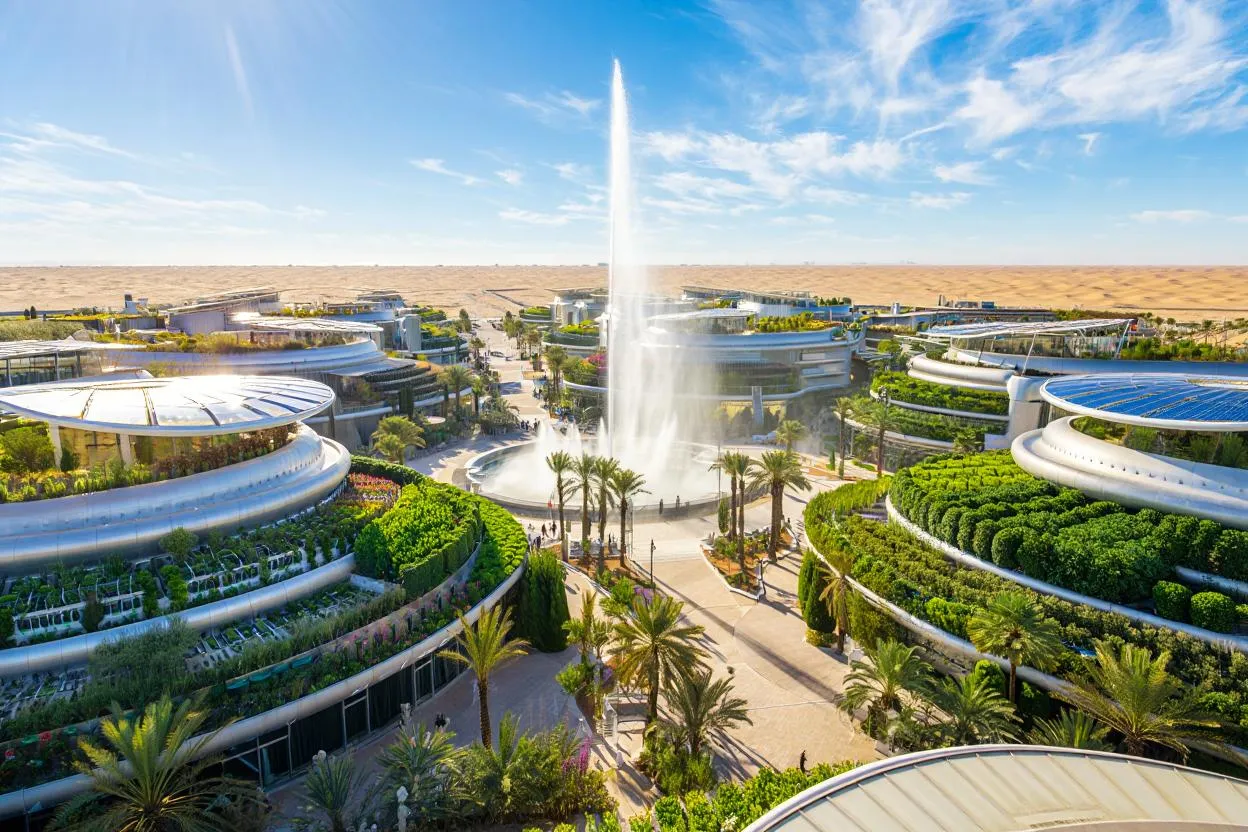

In [10]:
reve_t.collect()

By default, Pixeltable saves all generated media outputs to a media directory. We can see the file path by using the `fileurl` property.

In [11]:
reve_t.select(reve_t.new_image.fileurl).collect()

new_image_fileurl
file:///Users/alison-pxt/.pixeltable/media/6944d283087e4abe94f2d6aae3c54d7f/70/7034/6944d283087e4abe94f2d6aae3c54d7f_3_2_703497a11e2b4089b883a77c7d2b6b61.jpeg


### Control aspect ratio or model version

You can pass optional parameters to `reve.create()` to shape the output. This adds a second image column that renders in a square frame and locks to the `latest` model. We are also adding a destination to this computed column, so that the generated output image is no longer stored in our local Pixeltable database but rather in an s3 bucket.


In [12]:
reve_t.add_computed_column(
    new_image_sq=reve.create(
        reve_t.prompt,
        aspect_ratio='1:1',
        version='latest',
    ),
    destination='s3://pxt-cloud-demos/reve-creations',
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

prompt,new_image,new_image_sq
A solarpunk metropolis in the desert with urban agriculture and an oasis theme.,,

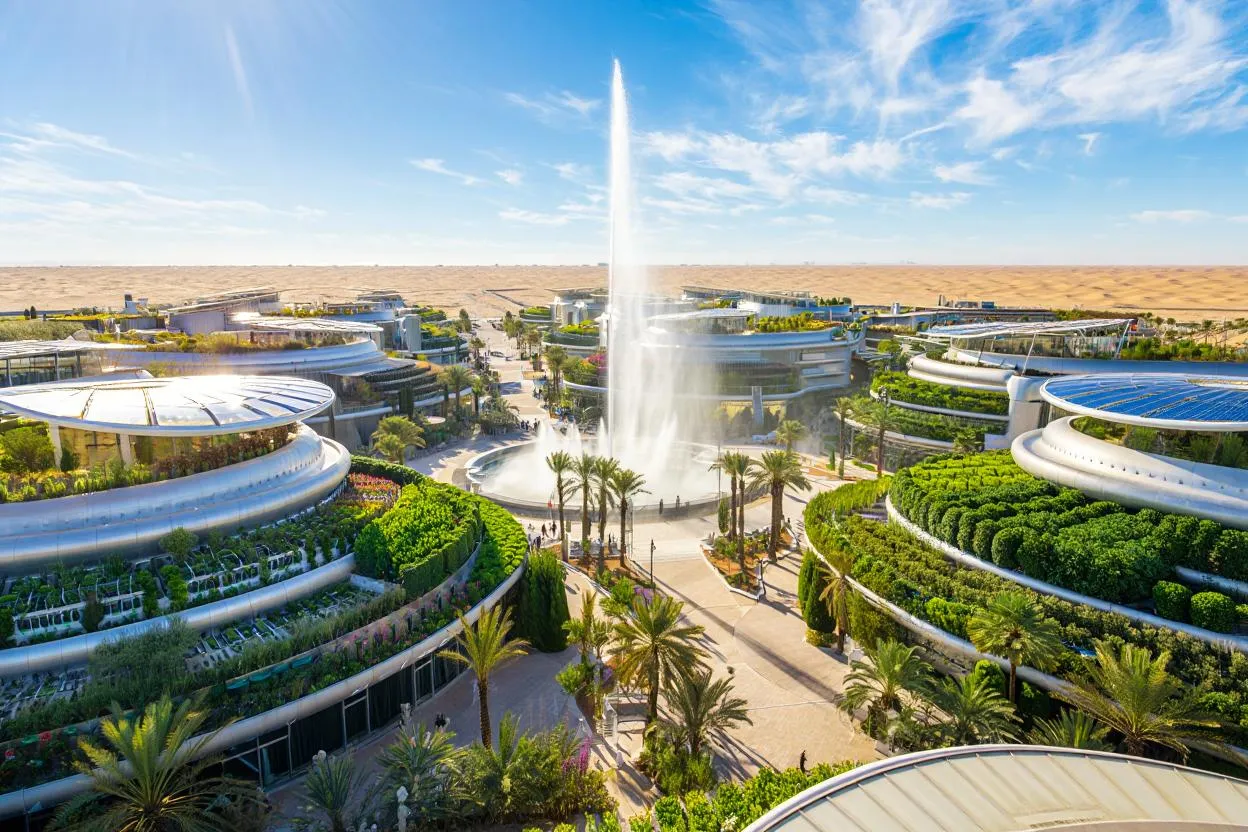
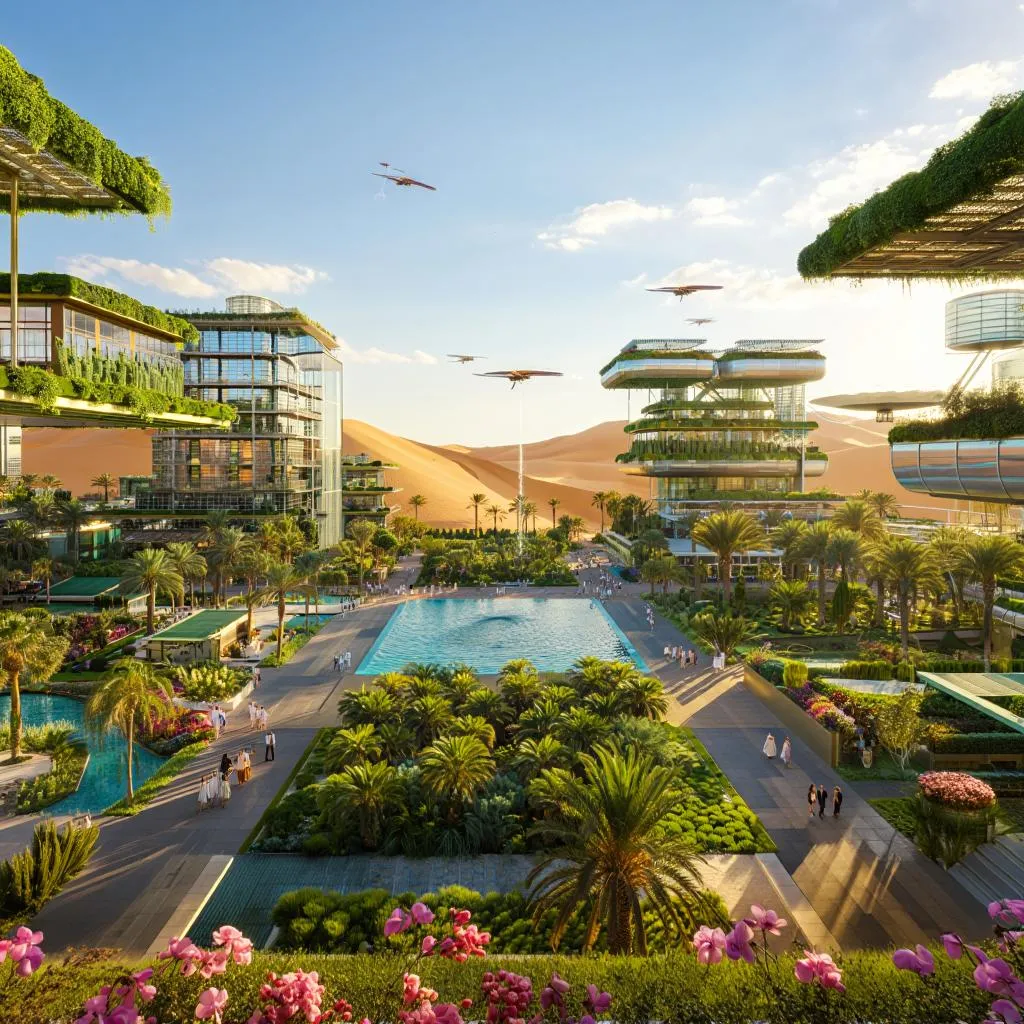

In [13]:
reve_t.collect()

In [14]:
reve_t.select(reve_t.new_image_sq.fileurl).collect()

new_image_sq_fileurl
s3://pxt-cloud-demos/reve-creations/6944d283087e4abe94f2d6aae3c54d7f/1b/1bf1/6944d283087e4abe94f2d6aae3c54d7f_4_3_1bf12e5836bb45de9508cdef2250dda8.jpeg


## Add a source photo for editing and remixing

Now we will expand the table with a column for reference images. We'll populate it with a sample photo from the COCO dataset so the later `edit` and `remix` steps have something to work with.

In [15]:
add_col_result = reve_t.add_column(source_image=pxt.Image)
add_col_result

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

In [16]:
image_url = 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000036.jpg'
reve_t.update({'source_image': image_url})

Inserting rows into `assets`: 1 rows [00:00, 809.09 rows/s]


1 row updated, 1 value computed.

source_image
""

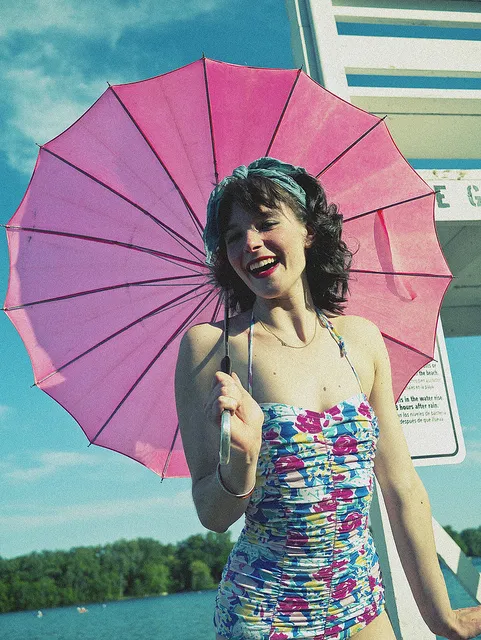

In [17]:
reve_t.select(reve_t.source_image).collect()

## Edit the original photo with `reve.edit`

`reve.edit()` takes an existing image plus natural-language instructions. We'll remove the background clutter and brighten the subject in our base street photo.

In [18]:
reve_t.add_computed_column(
    edited_subject=reve.edit(
        reve_t.source_image,
        'Remove the lifeguard chair in the background. Adjust the lighting in a solarpunk aesthetic that combines the optimistic, ecological themes of a bright, sustainable future with the artistic styles of Art Nouveau and organic architecture.'
    ),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

source_image,edited_subject
,

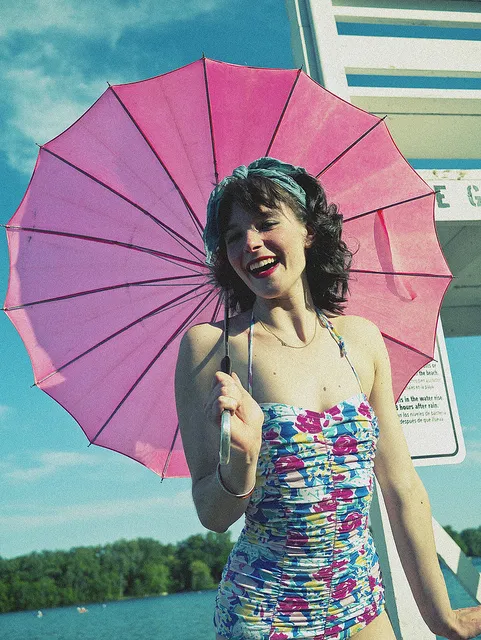
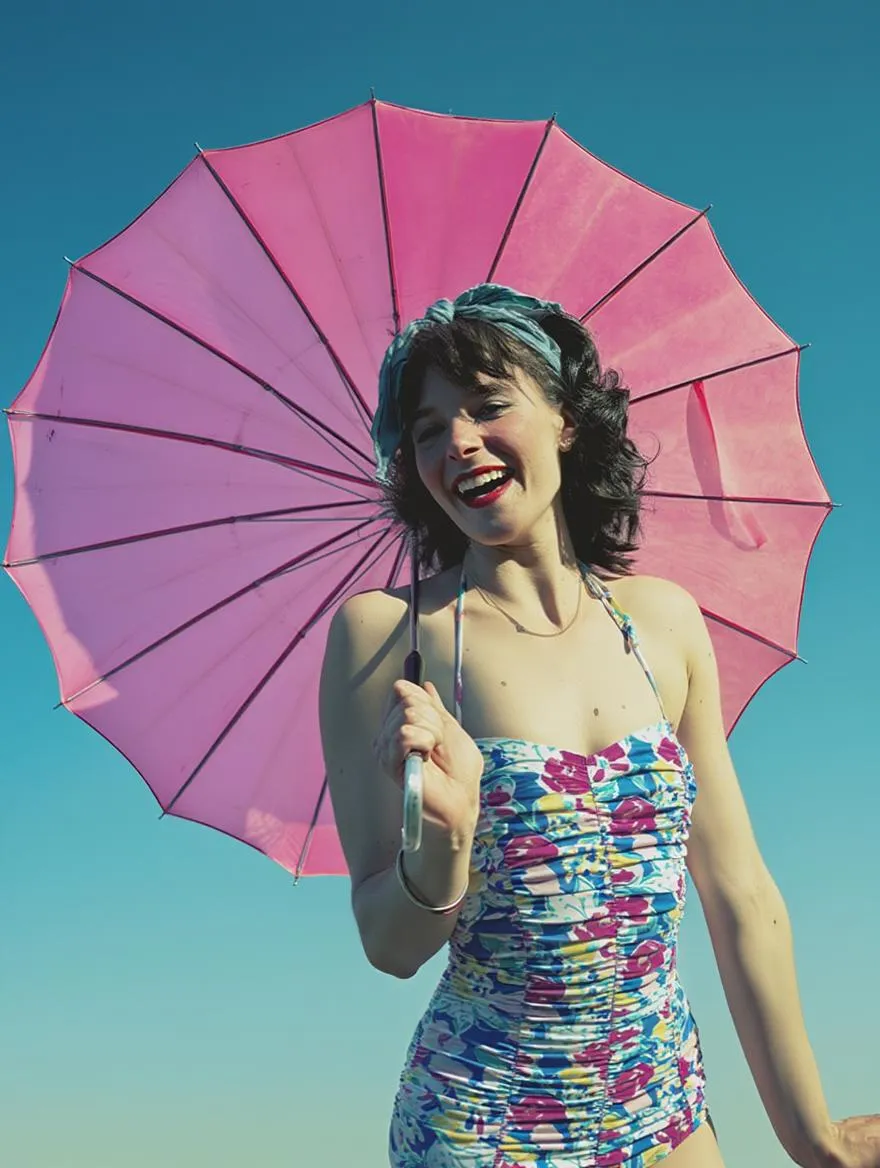

In [19]:
reve_t.select(reve_t.source_image, reve_t.edited_subject).collect()

## Remix multiple references with `reve.remix`

`reve.remix()` blends multiple reference images. Inside the prompt string, you reference each image with a numbered placeholder:
- `<img>0</img>` refers to `images[0]`
- `<img>1</img>` refers to `images[1]`
- etc.

Markdown sometimes hides these tags when documenting them, so we wrap them in backticks in the text above. In actual code, type them exactly as shown.

In the next cell we place the edited subject from `<img>0</img>` (the first entry in the `images` list) into the futuristic skyline from `<img>1</img>` (the second entry).


In [25]:
reve_t.add_computed_column(
    solarpunk_remix=reve.remix(
        'Place the girl with the beach umbrella from <img>0</img> on a high-rise looking out over the solarpunk metropolis from <img>1</img>.',
        images=[reve_t.edited_subject, reve_t.new_image],
        aspect_ratio='16:9',
    ),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

solarpunk_remix
""

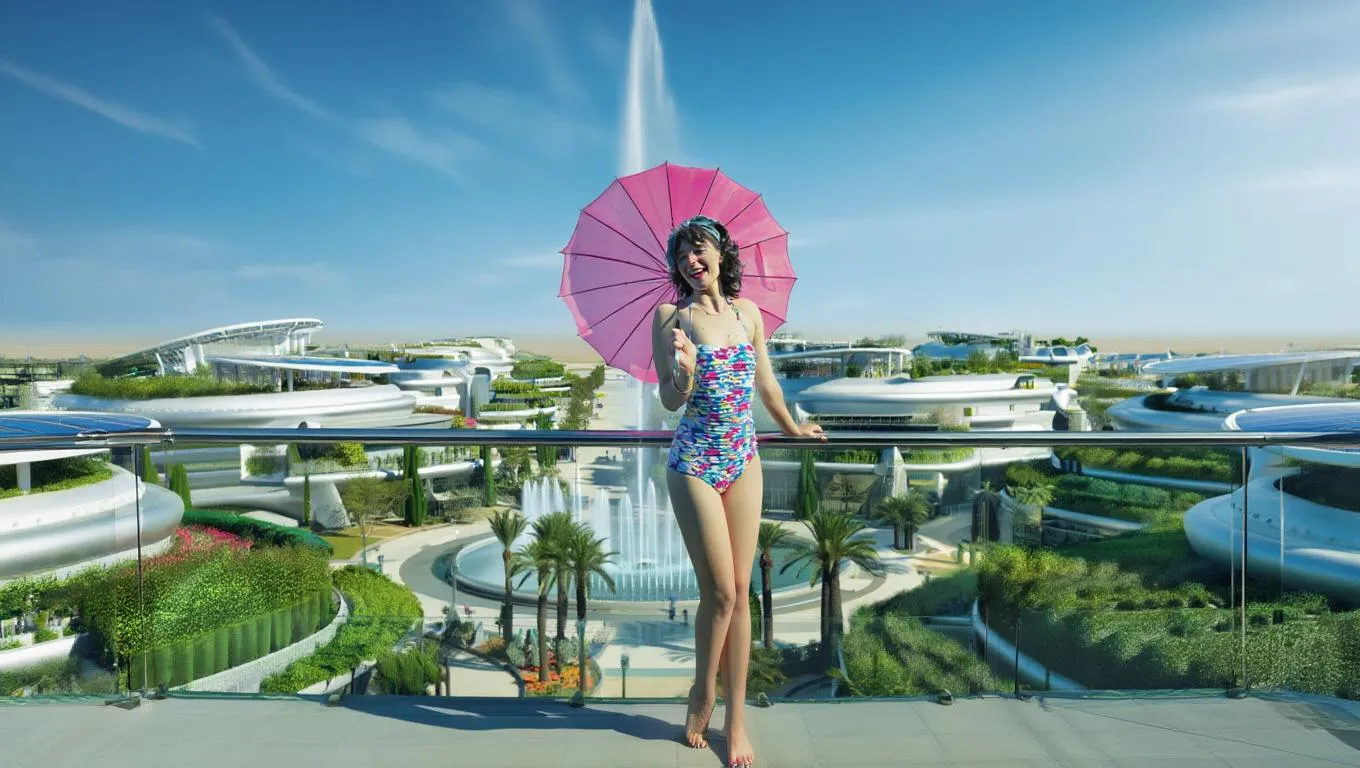

In [26]:
reve_t.select(reve_t.solarpunk_remix).collect()

## Review Reve in Pixeltable

Below is a quick recap of how each Reve function maps inputs to outputs inside Pixeltable tables. Each function reads from one or more columns and writes its results back into the same row so you can track the lineage end-to-end.

### `reve.create()`

- **Input column:** A prompt (or any text expression; storing it per row is optional but handy for auditing)
- **Output column:** Pixeltable creates a new image column for you
- **Usage reminder:** You can hardcode prompts directly inside `reve.create()` or keep them in a column if you want to reuse/tweak them later.


prompt,new_image,new_image_sq
A solarpunk metropolis in the desert with urban agriculture and an oasis theme.,,

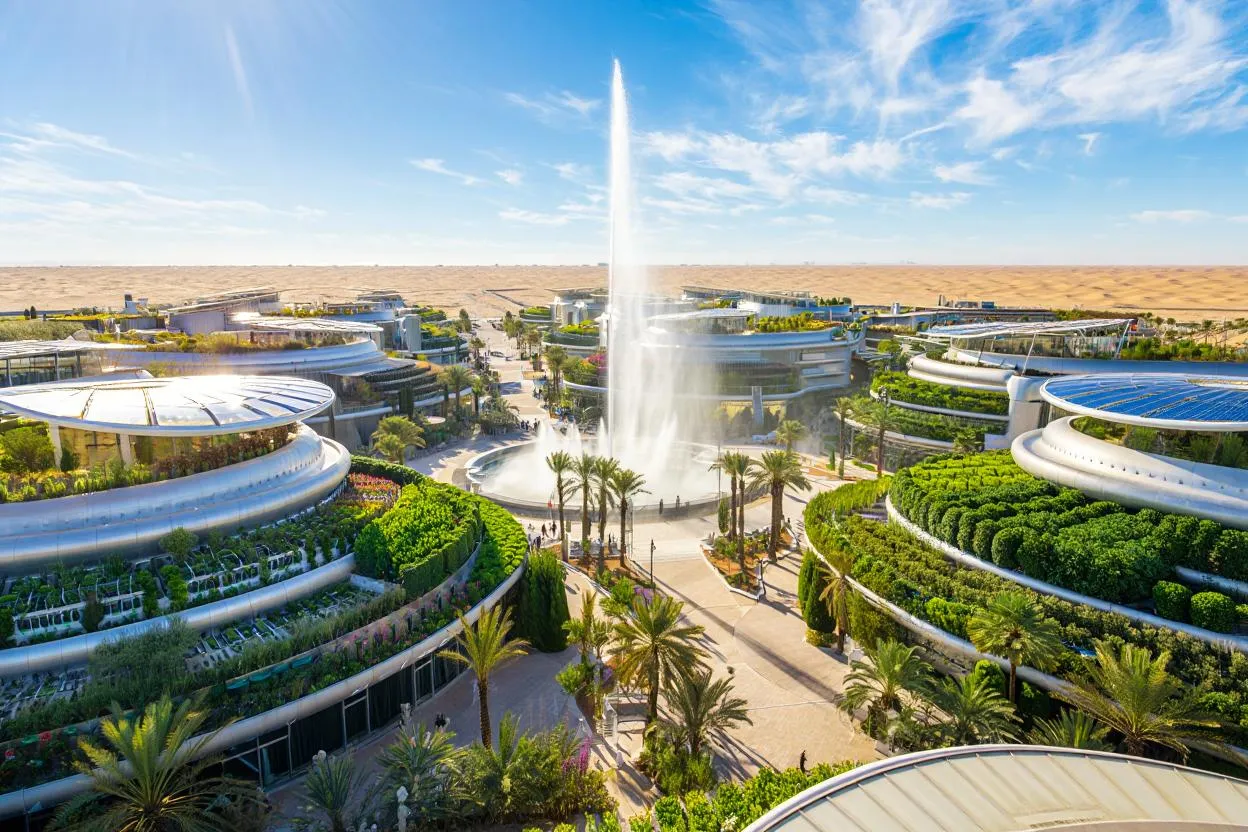
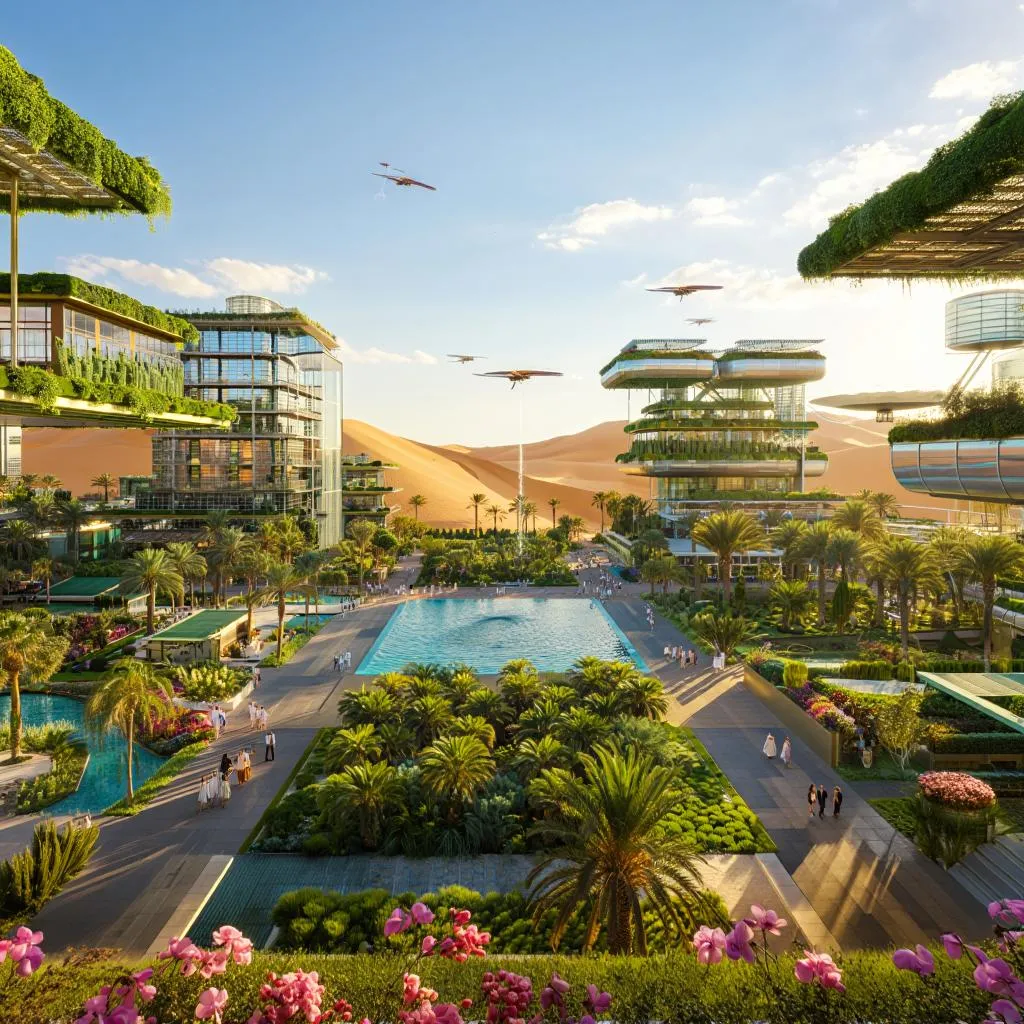

In [27]:
reve_t.select(
    reve_t.prompt,
    reve_t.new_image,
    reve_t.new_image_sq,
).collect()

### `reve.edit()`

- **Input column:** A source image of type `pxt.Image`
- **Output column:** Pixeltable creates a new image column for you
- **Usage reminder:** The edit instructions live inline inside the `add_computed_column()` call; store them in a separate column if you want to track versions.

source_image,edited_subject
,

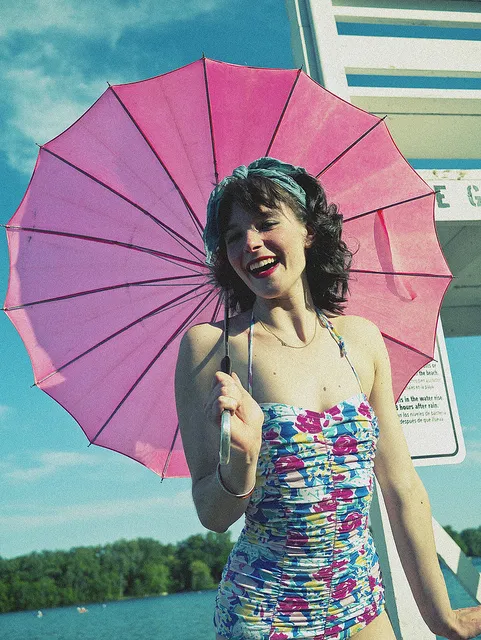
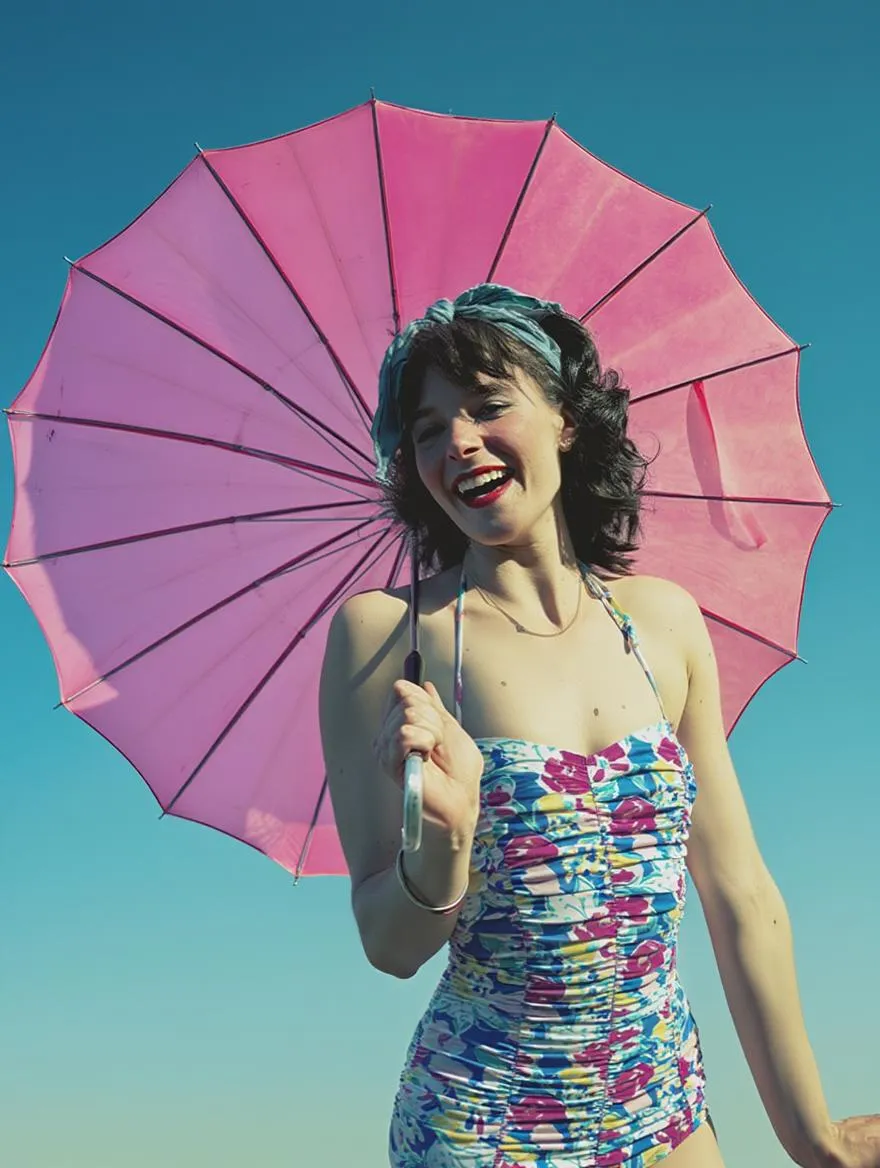

In [28]:
reve_t.select(
    reve_t.source_image,
    reve_t.edited_subject,
).collect()

### `reve.remix()`

- **Input columns:** We started with two image columns
- **How the prompt references them:**
  - `images=[my_table.image00, my_table.image01]`
  - Inside the prompt, `<img>0</img>` points at `images[0]` and `<img>1</img>` points at `images[1]`
- **Output column:** Pixeltable creates a new image column for you
- **Usage reminder:** Always keep the placeholders and the order of the `images` list in sync; add more `<img>n</img>` tags if you pass more reference images.


edited_subject,new_image,solarpunk_remix
,,

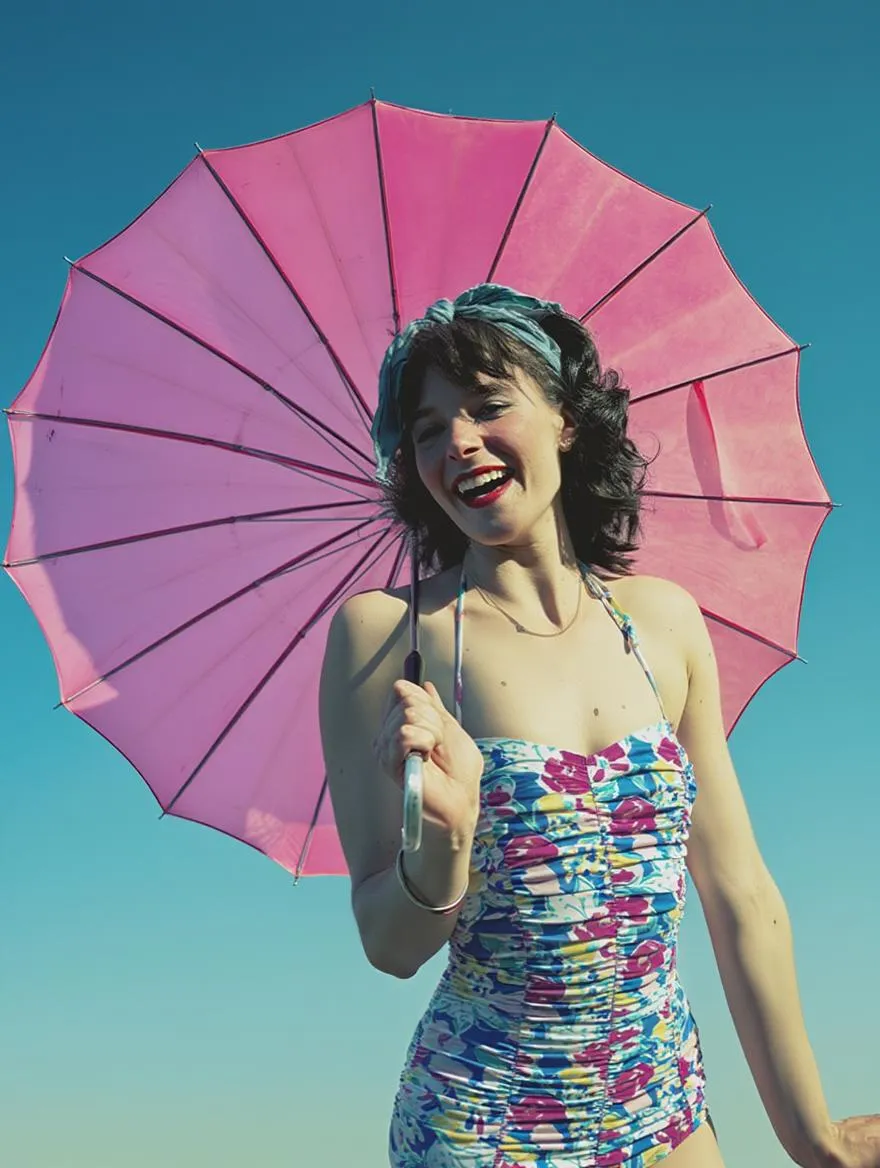
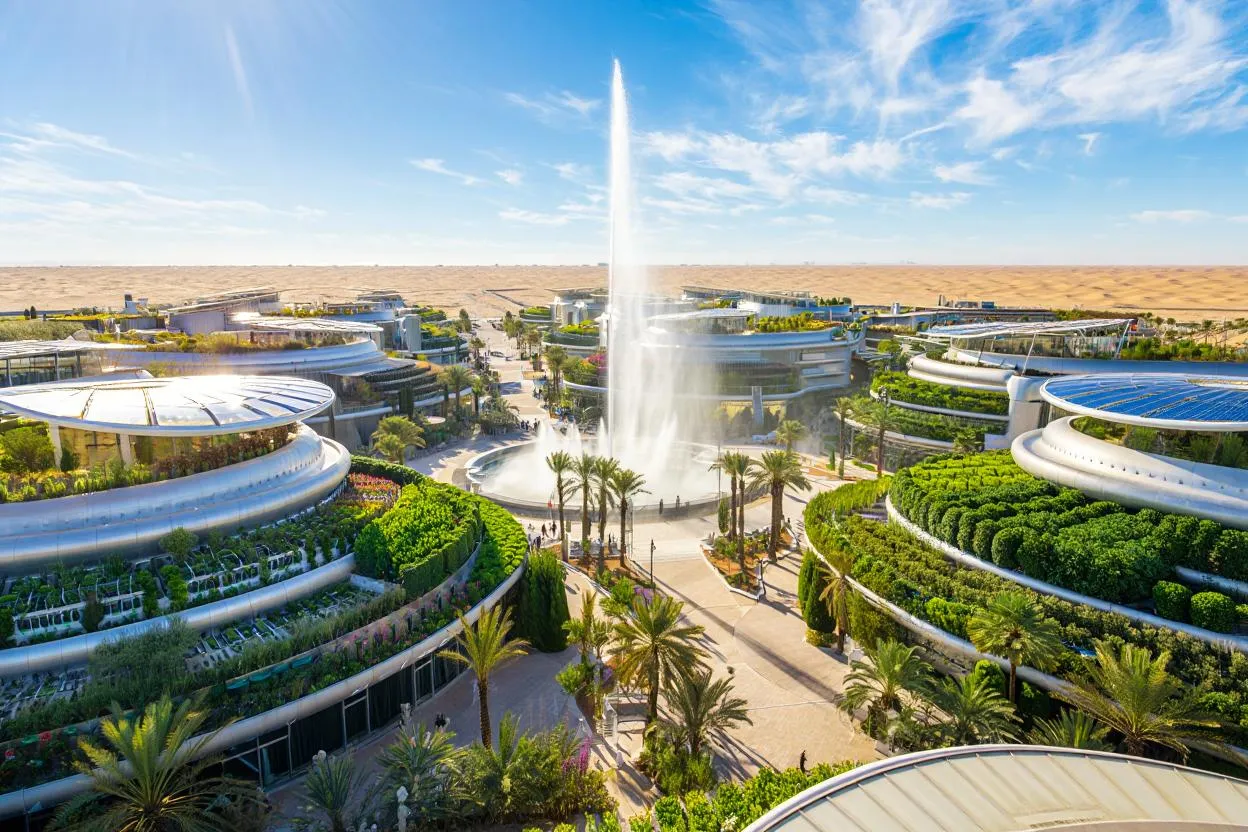
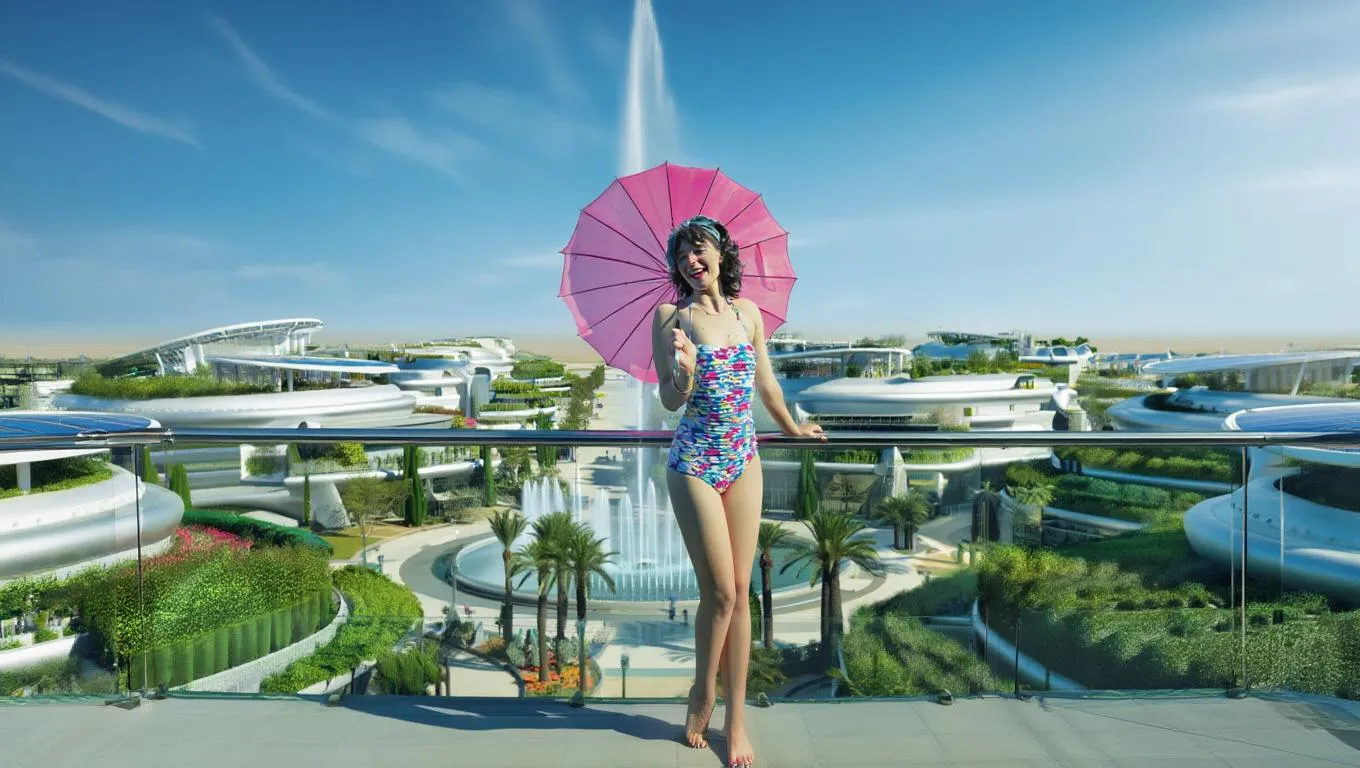

In [29]:
reve_t.select(
    reve_t.edited_subject,
    reve_t.new_image,
    reve_t.solarpunk_remix,
).collect()

## Learn more

- Reve API reference: <https://api.reve.com/console/docs>
- Pixeltable documentation: <https://docs.pixeltable.com/sdk/v0.4.24/reve#module-pixeltable-functions-reve>

If you build something with Reve, let us know!
